In [1]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from pathlib import Path
from sklearn.decomposition import FastICA
from sklearn.decomposition import PCA

def setup_mpl():
    mpl.rcParams['font.family'] = 'Times New Roman'
    mpl.rcParams['lines.linewidth'] = 2
    return None
setup_mpl()

In [2]:
data_dict = {}
for d in Path('../data/raw/dataset_extended').glob('D1_*'):
    d_name = d.name
    data_dict[d_name] = {}
    team_inf = pd.read_csv(list(d.glob('team_info.csv'))[0])
    for id_ in d.glob('ID_*'):
        id_name = id_.name
        data_dict[d_name][id_name] = {}
        
        for round_ in id_.glob('round_*'):
            round_name = round_.name
            data_dict[d_name][id_name][round_name] = {}
            
            for phase in round_.glob('phase*'):
                phase_name = phase.name
                data_dict[d_name][id_name][round_name][phase_name] = {} 
                
                response_df = pd.read_csv(list(phase.glob('response.csv'))[0], index_col=None)
                key = "participant_ID" if "participant_ID" in response_df.columns.tolist() else "particpant_ID"

                for file in phase.glob('*.csv'):
                    if file.name not in ('response.csv',): #TODO: change 
                        temp_df = pd.read_csv(file, index_col=None)
                        temp_df['time'] = pd.to_datetime(temp_df['time'], format='%Y-%m-%d %H:%M:%S.%f')
                        temp_df['time_passed'] = (temp_df['time'] - temp_df['time'].iloc[0]).apply(lambda x: x.total_seconds())

                        if team_inf[team_inf.ID == id_name]['Puzzler'].tolist()[0] == 0:
                            temp_df['role'] = 'Puzzler'
                        else:
                            temp_df['role'] = 'Instructor'
                        temp_df['team'] = team_inf[team_inf.ID == id_name]['Team'].tolist()[0]
                        if str(d.name)=='D1_2': #This is just stupid.. at least name them correctly yourself...
                            temp_df['p_ID'] = response_df[key].tolist()[0]+8
                        else:
                            temp_df['p_ID'] = response_df[key].tolist()[0]

                        # Save dataframe in nested dictionary
                        data_dict[d_name][id_name][round_name][phase_name][file.stem] = temp_df


# Heart rate

First let us start simple and then extend; meaning that first we will look into a single round, and get a working example, then we will extend to multiple individuals and then to multiple cohorts.

In [89]:
# lengths = [len(data_dict[cohort][id][round_][phase]['HR']['HR'].tolist()) for cohort in data_dict for id in data_dict[cohort] for round_ in data_dict[cohort][id] for phase in data_dict[cohort][id][round_]]

In [90]:
# mu_lengths = np.mean(lengths)
# std_lengths = np.std(lengths)

In [50]:
# min_len_hr = min(len(data_dict[cohort][id][round_][phase]['HR']['HR'].tolist()) for cohort in data_dict for id in data_dict[cohort] for round_ in data_dict[cohort][id] for phase in data_dict[cohort][id][round_] if len(data_dict[cohort][id][round_][phase]['HR']['HR'].tolist()) > mu_lengths - std_lengths)
# max_len_hr = max(len(data_dict[cohort][id][round_][phase]['HR']['HR'].tolist()) for cohort in data_dict for id in data_dict[cohort] for round_ in data_dict[cohort][id] for phase in data_dict[cohort][id][round_] if len(data_dict[cohort][id][round_][phase]['HR']['HR'].tolist()) > mu_lengths - std_lengths)
columns = ['ID', 'time', 'time_passed', 'D', 'round', 'phase', 'HR']
X = []
roles = []
phases = []
participant_ID = []

for cohort in data_dict.keys():
    for id in data_dict[cohort].keys():
        for round_ in data_dict[cohort][id].keys():
            for phase in data_dict[cohort][id][round_].keys():
                hr_ts = data_dict[cohort][id][round_][phase]['HR'].HR.tolist()
                time_ts = data_dict[cohort][id][round_][phase]['HR'].time.values.tolist()
                time_passed = data_dict[cohort][id][round_][phase]['HR'].time_passed.tolist()
                role = data_dict[cohort][id][round_][phase]['HR'].role.tolist()[0]
                p_id =  data_dict[cohort][id][round_][phase]['HR'].p_ID.tolist()[0]
                # BVPorary fix, appears that there might be an outlier that messes up the results
                #if max(hr_ts) > 90:
                #    continue
                
                # Removing series that differs from mean length with more than one standard deviation
                #if len(hr_ts) < mu_lengths - std_lengths:
                #    continue

                # Truncating
                #if len(hr_ts) > min_len_hr:
                #    hr_ts = hr_ts[:min_len_hr]
                #    time_ts = time_ts[:min_len_hr]
                #    time_passed = time_passed[:min_len_hr]

                # Zero padding
                if len(hr_ts) < 300:
                    hr_ts += [hr_ts[-1]] * (300 - len(hr_ts))
                elif len(hr_ts) > 300:
                    hr_ts = hr_ts[:300]
                roles.append(role)
                phases.append(phase)
                participant_ID.append(p_id)
                X += [hr_ts]

roles = np.array(roles)
phases = np.array(phases)
X = np.vstack(X)
X.shape

(312, 300)

In [51]:
X_new = np.hstack([X,np.array(participant_ID).reshape(-1,1)])
X_new = np.hstack([X_new, np.array(phases).reshape(-1,1)])
#X_new = np.hstack([X_new, roles.reshape(-1,1)])
col_names = [f'{i}' for i in range(300)]
col_names.append('ID')
col_names.append('Phases')
#col_names.append('Role')
X_new = pd.DataFrame(X_new, columns=col_names)
X = np.array(X_new.groupby(['ID','Phases']).median())

In [52]:
temp = X_new.groupby(['ID','Phases']).median()
phase1_idx = np.array(temp.reset_index()[temp.reset_index()['Phases']=='phase1'].index)
phase2_idx = np.array(temp.reset_index()[temp.reset_index()['Phases']=='phase2'].index)
phase3_idx = np.array(temp.reset_index()[temp.reset_index()['Phases']=='phase3'].index)

In [53]:
from ast import literal_eval
participant_ID = np.round(participant_ID)
new_participant_ID = []
new_phase_idx = [] 
puzzler_idx = []
instructor_idx = []
for i, (ID, phase) in enumerate(temp.index):
    idx = np.argwhere((participant_ID==literal_eval(ID)) & (np.array(phases)==phase))
    if roles[idx][0][0] == 'Puzzler':
        puzzler_idx.append(i)
    else:
        instructor_idx.append(i)
    new_participant_ID.append(ID)
    new_phase_idx.append(phase)
participant_ID = new_participant_ID



In [54]:
def unit_normalize(X):
    row_norms = np.linalg.norm(X, axis=1, keepdims=True)
    return X / row_norms

X = unit_normalize(X)

In [55]:
#len(participant_ID) #These are the participant ID's for all our grouped observations
#phase1_idx
#phase2_idx
#phase3_idx

#X.shape
#outlier = None
#mask = np.ones(len(phases), dtype=bool)
#mask[outlier] = False
#X = X[mask, :]
#phases = phases[mask]
#roles = roles[mask]

In [56]:
from py_pcha import PCHA
# Notice that for this implementation we transform the data matrix X
XC, S, C, SSE, varexl = PCHA(X.T, noc=3)
X_hat = X.T @ C @ S
components = XC.T

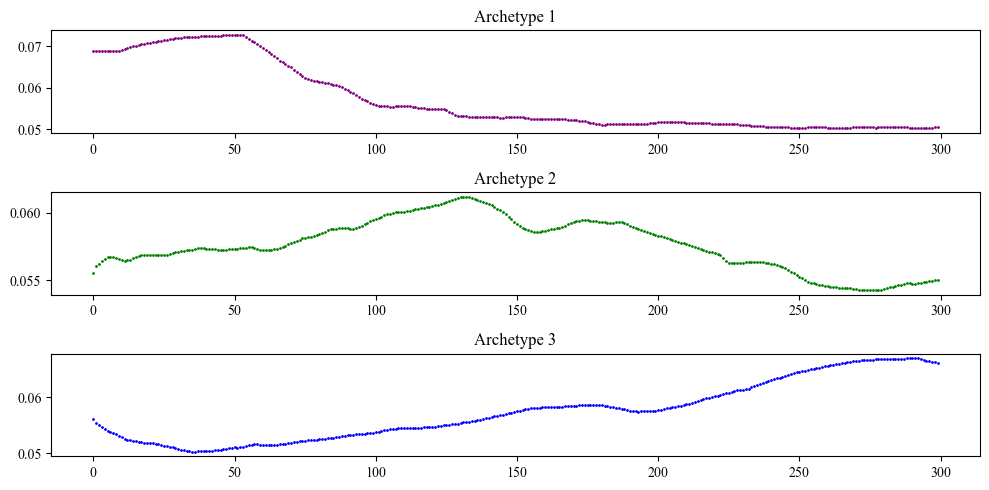

In [57]:
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(10, 5))
ax1.plot(components[0, :].T, 'o', markersize=1, label='Archetype 1', c='purple')
ax1.set_title('Archetype 1')
ax2.plot(components[1, :].T, 'o', markersize=1, label='Archetype 2', c='green')
ax2.set_title('Archetype 2')
ax3.plot(components[2, :].T, 'o', markersize=1, label='Archetype 3', c='blue')
ax3.set_title('Archetype 3')
fig.tight_layout()
plt.show()

# Time series clustering / dimensionality reduction

In [58]:
#puzzler_idx = np.where(roles=='Puzzler')[0]
#instructor_idx = np.where(roles=='Instructor')[0]

In [59]:
X.shape, len(participant_ID)

((78, 300), 78)

In [60]:
def colour_map(ids):
    import random
    levels = range(32, 256, 32)
    random_colours = {}
    for id in ids:
        random_colours[id] = tuple(random.choice(levels)/255 for _ in range(3))
    return random_colours

cmap_id = colour_map(participant_ID)

In [61]:
cmap_id

{'1.0': (0.8784313725490196, 0.3764705882352941, 0.12549019607843137),
 '10.0': (0.6274509803921569, 0.8784313725490196, 0.5019607843137255),
 '11.0': (0.3764705882352941, 0.3764705882352941, 0.5019607843137255),
 '12.0': (0.3764705882352941, 0.6274509803921569, 0.6274509803921569),
 '13.0': (0.5019607843137255, 0.12549019607843137, 0.5019607843137255),
 '14.0': (0.12549019607843137, 0.8784313725490196, 0.3764705882352941),
 '15.0': (0.5019607843137255, 0.8784313725490196, 0.12549019607843137),
 '16.0': (0.7529411764705882, 0.8784313725490196, 0.8784313725490196),
 '17.0': (0.7529411764705882, 0.8784313725490196, 0.25098039215686274),
 '18.0': (0.8784313725490196, 0.3764705882352941, 0.6274509803921569),
 '19.0': (0.8784313725490196, 0.3764705882352941, 0.12549019607843137),
 '2.0': (0.7529411764705882, 0.7529411764705882, 0.7529411764705882),
 '20.0': (0.3764705882352941, 0.25098039215686274, 0.6274509803921569),
 '21.0': (0.7529411764705882, 0.6274509803921569, 0.5019607843137255),
 

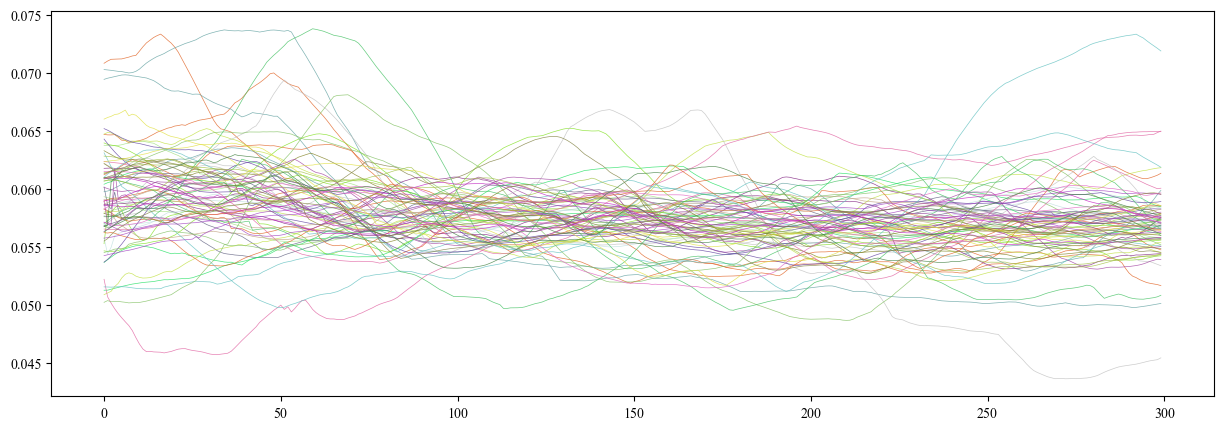

In [62]:
#All heart rates
fig, ax = plt.subplots(figsize=(15, 5))
for i in range(len(X)):
    ax.plot([i for i in range(len(X[i, :]))], X[i, :], alpha=0.8, c=cmap_id[participant_ID[i]], linewidth=0.5)
plt.show()

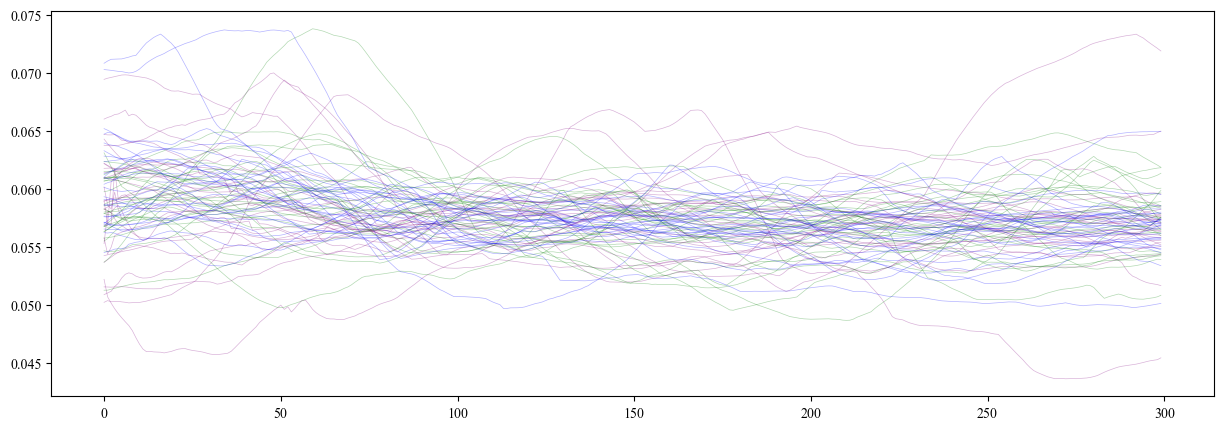

In [63]:
#The HR's grouped by the true phases

fig, ax = plt.subplots(figsize=(15, 5), dpi=100)
for idx in phase1_idx:
    ax.plot(X[idx, :], alpha=0.3, c='purple', linewidth=0.5)

for idx in phase2_idx:
    ax.plot(X[idx, :], alpha=0.3, c='green', linewidth=0.5)

for idx in phase3_idx:
    ax.plot(X[idx, :], alpha=0.3, c='blue', linewidth=0.5)

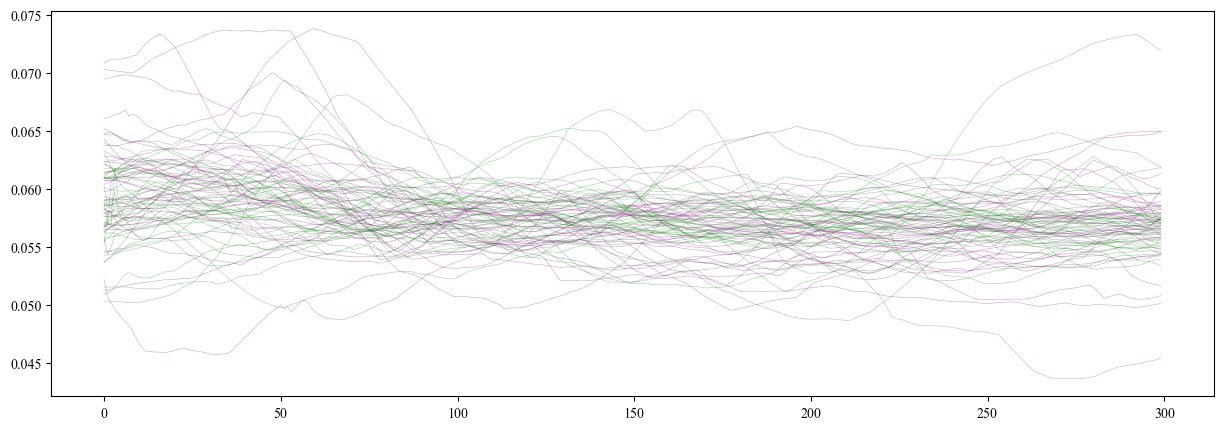

In [18]:
#The HR of the individuals grouped the true values of the roles:
fig, ax = plt.subplots(figsize=(15, 5), dpi=100)
for idx in puzzler_idx:
    ax.plot(X[idx, :], alpha=0.3, c='purple', linewidth=0.5)

for idx in instructor_idx:
    ax.plot(X[idx, :], alpha=0.3, c='green', linewidth=0.5)

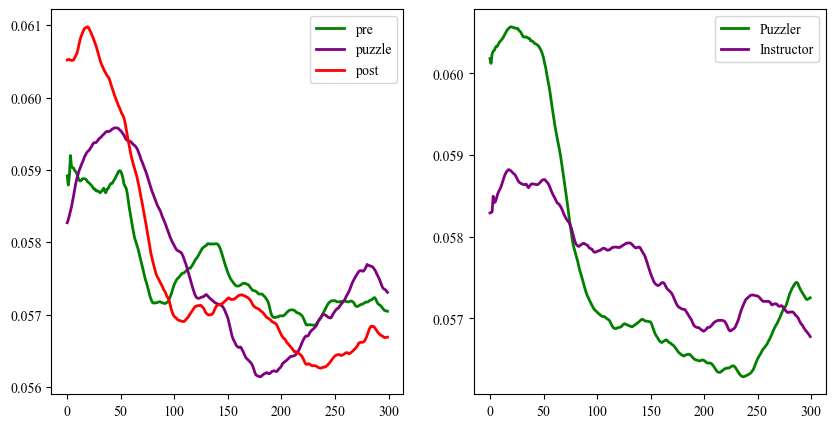

In [64]:
#Here the true mean HR's are plotted based on the three phases or roles:

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,5))
ax1.plot(X[phase1_idx, :].mean(axis=0), c='green', label='pre')
ax1.plot(X[phase2_idx, :].mean(axis=0), c='purple', label='puzzle')
ax1.plot(X[phase3_idx, :].mean(axis=0), c='red', label='post')
ax1.legend()

ax2.plot(X[puzzler_idx, :].mean(axis=0), c='green', label='Puzzler')
ax2.plot(X[instructor_idx, :].mean(axis=0), c='purple', label='Instructor')
ax2.legend()
plt.show()

In [65]:
#Now we perform AA again
from py_pcha import PCHA
X_BVP = X.copy()
# Notice that for this implementation we transform the data matrix X
XC, S, C, SSE, varexl = PCHA(X_BVP.T, noc=3)
X_hat = X_BVP.T @ C @ S
components = XC.T

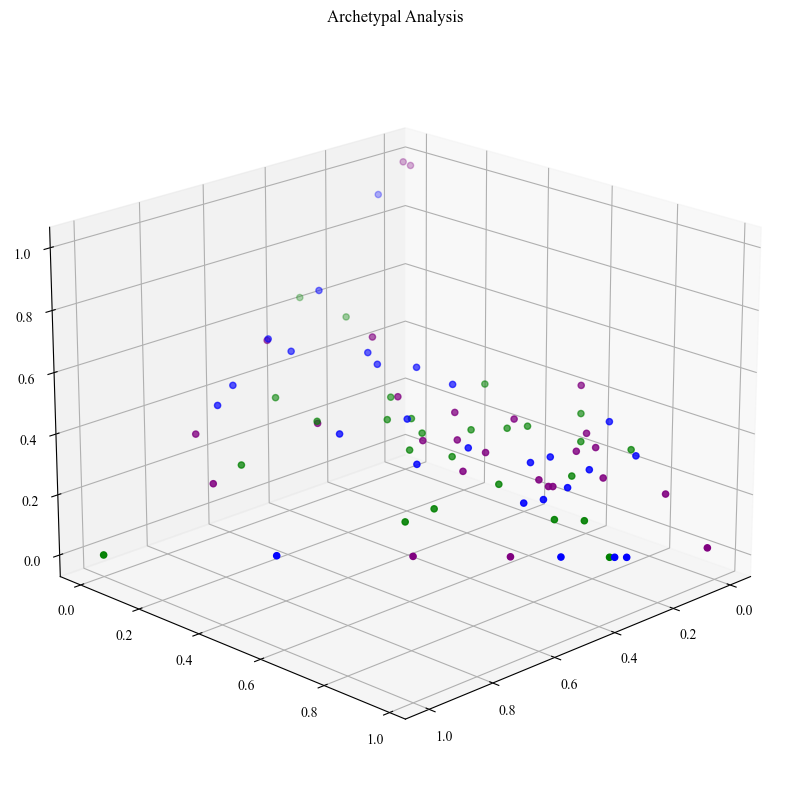

In [66]:
#The data plotted in the AA space
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(projection='3d')
ax.scatter(S[0,phase1_idx], S[1,phase1_idx], S[2, phase1_idx], c='purple', marker='o', label='phase1')
ax.scatter(S[0,phase2_idx], S[1,phase2_idx], S[2, phase2_idx], c='blue', marker='o', label='phase2')
ax.scatter(S[0,phase3_idx], S[1,phase3_idx], S[2, phase3_idx], c='green', marker='o', label='phase3')
ax.set_title('Archetypal Analysis')
ax.view_init(elev=20, azim=45)
plt.show()

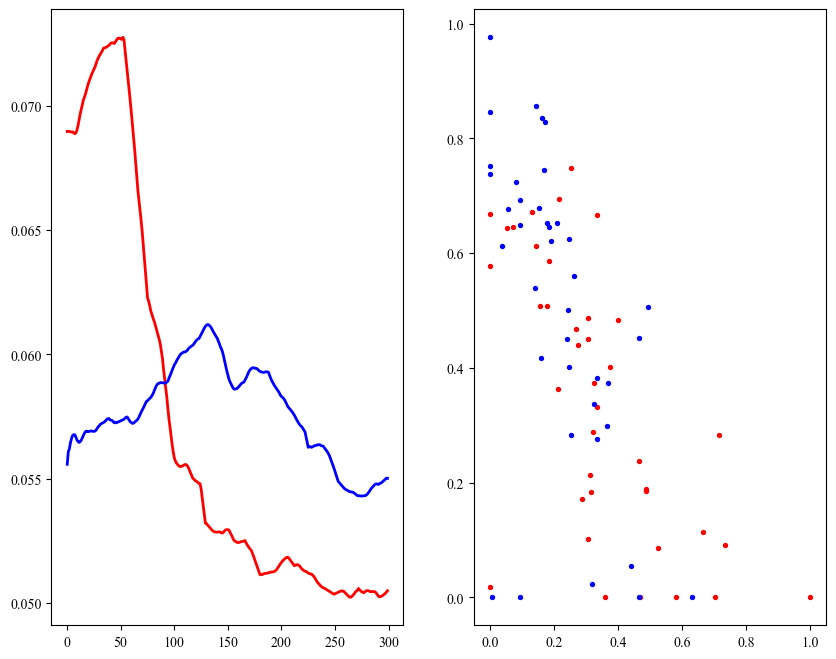

In [67]:
#We take the two first components of the AA and

fig, (ax1, ax2) = plt.subplots(1,2, figsize=(10,8))
ax1.plot(XC[:, 0], c='red')
ax1.plot(XC[:, 1], c='blue')
#ax1.plot(XC[:, 2], c='purple')
ax2.scatter(np.asarray(S)[0, puzzler_idx], np.asarray(S)[1, puzzler_idx], c='red', s=8)
ax2.scatter(np.asarray(S)[0, instructor_idx], np.asarray(S)[1, instructor_idx], c='blue', s=8)
plt.show()

In [68]:
#S.shape
#cmap_id

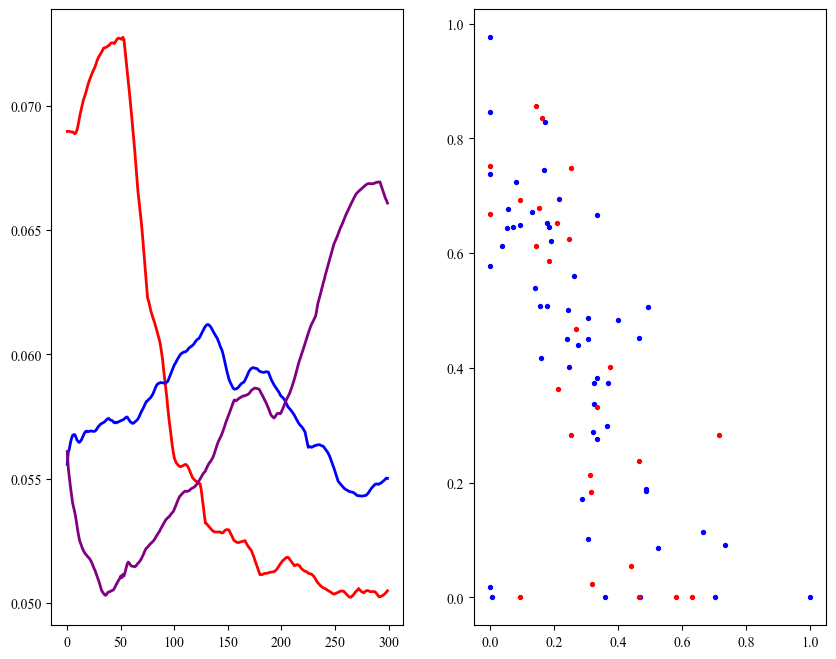

In [69]:
#I think we plot the HR of the three archetypes and see if we can discern participants based on the latent space
#of the two archetypes?

fig, (ax1, ax2) = plt.subplots(1,2, figsize=(10,8))
ax1.plot(XC[:, 0], c='red')
ax1.plot(XC[:, 1], c='blue')
ax1.plot(XC[:, 2], c='purple')
#for obs, id in enumerate(participant_ID):
#    ax2.scatter(np.asarray(S)[0, obs], np.asarray(S)[1, obs], c=cmap_id[id], s=8)

ax2.scatter(np.asarray(S)[0, phase1_idx], np.asarray(S)[1, phase1_idx], s=8, c='blue')
ax2.scatter(np.asarray(S)[0, phase3_idx], np.asarray(S)[1, phase3_idx], s=8, c='blue', label='Not-puzzle')
ax2.scatter(np.asarray(S)[0, phase2_idx], np.asarray(S)[1, phase2_idx], s=8, c='red', label='Puzzle')

plt.show()

In [25]:
np.unique(participant_ID)

array(['1.0', '10.0', '11.0', '12.0', '13.0', '14.0', '15.0', '16.0',
       '17.0', '18.0', '19.0', '2.0', '20.0', '21.0', '22.0', '23.0',
       '24.0', '25.0', '26.0', '3.0', '4.0', '5.0', '6.0', '7.0', '8.0',
       '9.0'], dtype='<U4')

In [26]:
XC.shape, S.shape, C.shape

((300, 3), (3, 78), (78, 3))

In [27]:
#Vi laver PCA på det latente space udspændt af de tre archetypes?
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
pca.fit(np.asarray(S))

PCA(n_components=2)

In [28]:
PC1, PC2 = pca.components_[0, :], pca.components_[1, :]

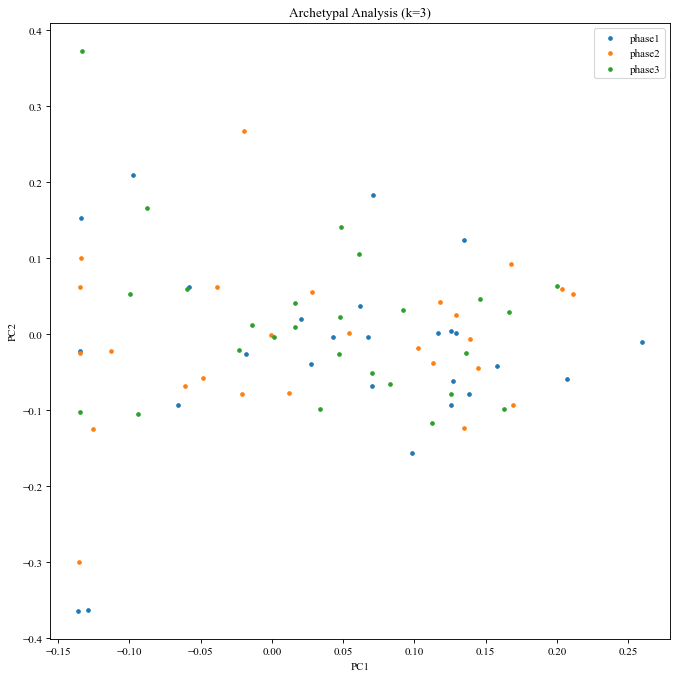

In [29]:
fig, ax = plt.subplots(figsize=(10,10), dpi=80)
ax.scatter(PC1[phase1_idx], PC2[phase1_idx], s=10, label='phase1')
ax.scatter(PC1[phase2_idx], PC2[phase2_idx], s=10, label='phase2')
ax.scatter(PC1[phase3_idx], PC2[phase3_idx], s=10, label='phase3')
ax.set_title('Archetypal Analysis (k=3)')
ax.set_xlabel('PC1')
ax.set_ylabel('PC2')
ax.legend()
plt.show()

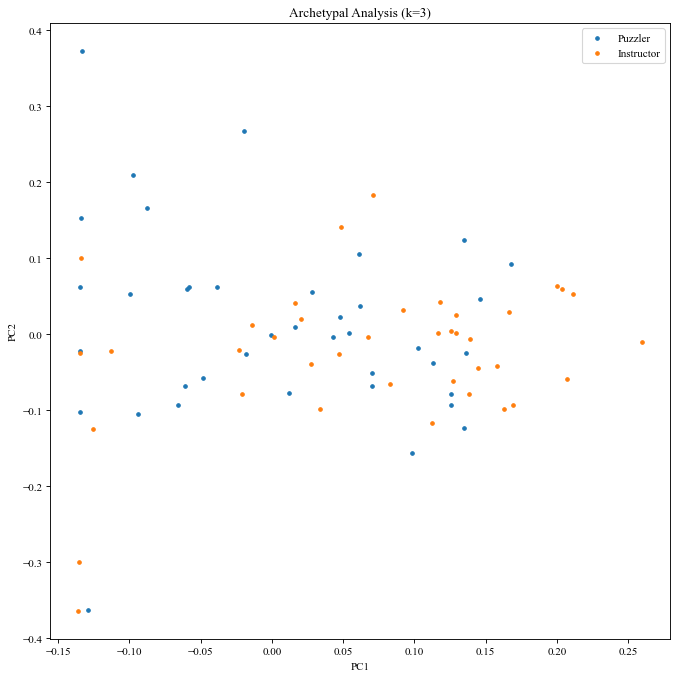

In [30]:
fig, ax = plt.subplots(figsize=(10,10), dpi=80)
ax.scatter(PC1[puzzler_idx], PC2[puzzler_idx], s=10, label='Puzzler')
ax.scatter(PC1[instructor_idx], PC2[instructor_idx], s=10, label='Instructor')
ax.set_title('Archetypal Analysis (k=3)')
ax.set_xlabel('PC1')
ax.set_ylabel('PC2')
ax.legend()
plt.show()

# Series plots

We will use archetypal maximum membership assignment:

In [31]:
amma = np.asarray(np.argmax(S, axis=0)).flatten()

In [32]:
amma.shape, amma

((78,),
 array([0, 0, 0, 1, 2, 1, 1, 1, 2, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        2, 1, 1, 2, 0, 2, 2, 2, 1, 1, 1, 1, 2, 1, 2, 2, 0, 1, 1, 1, 2, 2,
        1, 1, 0, 1, 2, 0, 2, 1, 1, 2, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0,
        1, 2, 1, 1, 2, 1, 2, 1, 1, 1, 1, 2], dtype=int64))

Then we will try to find a single point nearest to each archetype:

In [33]:
N = 40

In [34]:
nearest = np.argsort(np.asarray(S), axis=1)[:, -N:]
nearest, nearest.shape

(array([[61, 67, 35, 73, 54, 48, 17, 29,  3, 37, 22, 25, 36, 77, 62,  8,
          4, 75, 60, 50, 59, 20, 10, 56, 34, 64, 26, 70, 72, 65, 63, 33,
         38,  1, 46,  2,  9, 49,  0, 11],
        [17, 26, 73, 56,  3, 12, 33, 23, 21, 14, 35, 15, 55, 47, 40, 69,
         19, 39,  5, 57, 51, 58, 45, 60, 16, 41,  6, 31, 52, 74, 30, 32,
         68, 61,  7, 44, 13, 24, 76, 18],
        [ 5, 75, 54,  9, 64, 62, 39, 71, 23, 14, 63, 65, 16, 59,  4, 21,
         77, 47, 66, 46, 38,  8, 36,  1, 15, 28, 53, 67, 37, 22, 34, 72,
         70, 48, 29, 50, 25, 43, 27, 42]], dtype=int64),
 (3, 40))

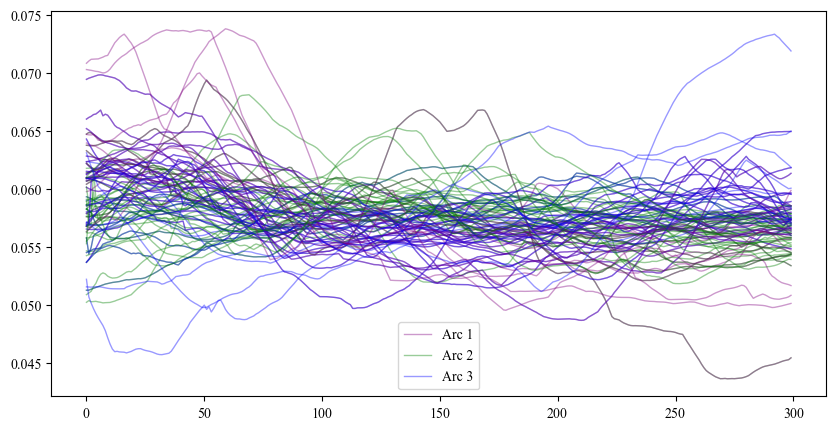

In [35]:
fig, ax = plt.subplots(figsize=(10, 5), dpi=100)
for i in range(N):
    if i == N-1:
        ax.plot(X[nearest[0, i], :], c='purple', linewidth=1, alpha=0.4, label='Arc 1')
        ax.plot(X[nearest[1, i], :], c='green', linewidth=1, alpha=0.4, label='Arc 2')
        ax.plot(X[nearest[2, i], :], c='blue', linewidth=1, alpha=0.4, label='Arc 3')
    else:
        ax.plot(X[nearest[0, i], :], c='purple', linewidth=1, alpha=0.4)
        ax.plot(X[nearest[1, i], :], c='green', linewidth=1, alpha=0.4)
        ax.plot(X[nearest[2, i], :], c='blue', linewidth=1, alpha=0.4)
ax.legend()
plt.show()

In [36]:
np.unique(phases[nearest[0, :]], return_counts=True), np.unique(phases[nearest[1, :]], return_counts=True), np.unique(phases[nearest[2, :]], return_counts=True)

((array(['phase1', 'phase2', 'phase3'], dtype='<U6'),
  array([11, 14, 15], dtype=int64)),
 (array(['phase1', 'phase2', 'phase3'], dtype='<U6'),
  array([15, 12, 13], dtype=int64)),
 (array(['phase1', 'phase2', 'phase3'], dtype='<U6'),
  array([13, 13, 14], dtype=int64)))

In [37]:
np.unique(roles[nearest[0,:]], return_counts=True), np.unique(roles[nearest[1,:]], return_counts=True)

((array(['Instructor', 'Puzzler'], dtype='<U10'),
  array([17, 23], dtype=int64)),
 (array(['Instructor', 'Puzzler'], dtype='<U10'),
  array([13, 27], dtype=int64)))

# EDA

In [38]:
X = []
roles = []
phases = []
participant_ID = []

for cohort in data_dict.keys():
    for id in data_dict[cohort].keys():
        for round_ in data_dict[cohort][id].keys():
            for phase in data_dict[cohort][id][round_].keys():
                eda_ts = data_dict[cohort][id][round_][phase]['EDA'].EDA.tolist()
                time_ts = data_dict[cohort][id][round_][phase]['EDA'].time.values.tolist()
                time_passed = data_dict[cohort][id][round_][phase]['EDA'].time_passed.tolist()
                role = data_dict[cohort][id][round_][phase]['EDA'].role.tolist()[0]
                p_id =  data_dict[cohort][id][round_][phase]['EDA'].p_ID.tolist()[0]

                # Zero padding
                if len(eda_ts) < 1200: # 1200 equals 5 min x 60 sec x 4 samples pr second
                    eda_ts += [eda_ts[-1]] * (1200 - len(eda_ts))
                elif len(eda_ts) > 1200:
                    eda_ts = eda_ts[:1200]
                roles.append(role)
                phases.append(phase)
                participant_ID.append(p_id)
                X += [eda_ts]

roles = np.array(roles)
phases = np.array(phases)
X = np.vstack(X)
X.shape

(312, 1200)

In [39]:
X_new = np.hstack([X,np.array(participant_ID).reshape(-1,1)])
X_new = np.hstack([X_new, np.array(phases).reshape(-1,1)])
#X_new = np.hstack([X_new, roles.reshape(-1,1)])
col_names = [f'{i}' for i in range(1200)]
col_names.append('ID')
col_names.append('Phases')
#col_names.append('Role')
#X_new.shape
X_new = pd.DataFrame(X_new, columns=col_names)
X = np.array(X_new.groupby(['ID','Phases']).median())

In [40]:
temp = X_new.groupby(['ID','Phases']).median()
phase1_idx = np.array(temp.reset_index()[temp.reset_index()['Phases']=='phase1'].index)
phase2_idx = np.array(temp.reset_index()[temp.reset_index()['Phases']=='phase2'].index)
phase3_idx = np.array(temp.reset_index()[temp.reset_index()['Phases']=='phase3'].index)

In [41]:
X = unit_normalize(X)

In [42]:
from py_pcha import PCHA
# Notice that for this implementation we transform the data matrix X
XC, S, C, SSE, varexl = PCHA(X.T, noc=3)
X_hat = X.T @ C @ S
components = XC.T

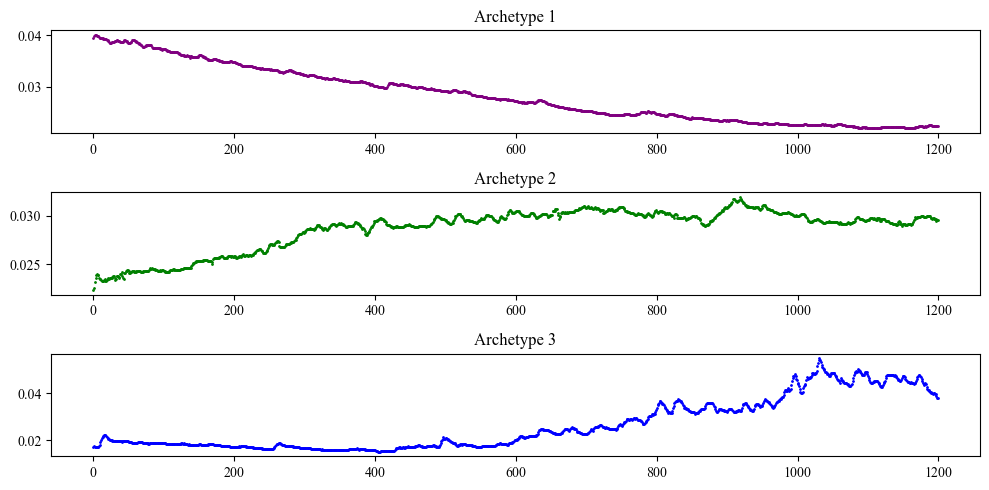

In [43]:
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(10, 5))
ax1.plot(components[0, :].T, 'o', markersize=1, label='Archetype 1', c='purple')
ax1.set_title('Archetype 1')
ax2.plot(components[1, :].T, 'o', markersize=1, label='Archetype 2', c='green')
ax2.set_title('Archetype 2')
ax3.plot(components[2, :].T, 'o', markersize=1, label='Archetype 3', c='blue')
ax3.set_title('Archetype 3')
fig.tight_layout()
plt.show()

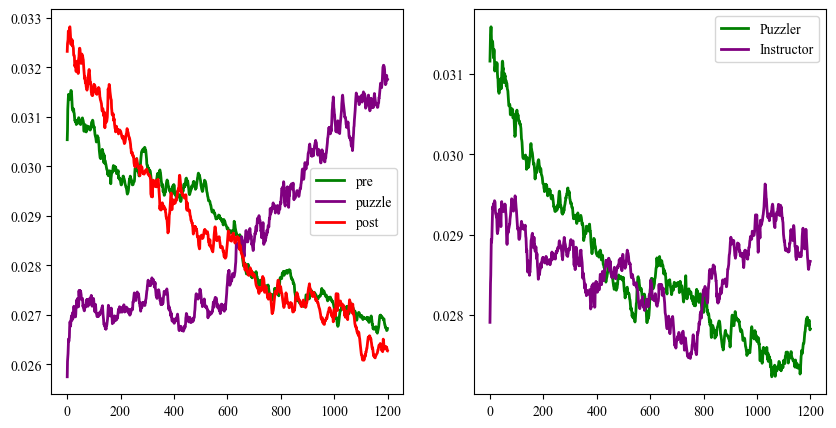

In [44]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,5))
ax1.plot(X[phase1_idx, :].mean(axis=0), c='green', label='pre')
ax1.plot(X[phase2_idx, :].mean(axis=0), c='purple', label='puzzle')
ax1.plot(X[phase3_idx, :].mean(axis=0), c='red', label='post')
ax1.legend()

ax2.plot(X[puzzler_idx, :].mean(axis=0), c='green', label='Puzzler')
ax2.plot(X[instructor_idx, :].mean(axis=0), c='purple', label='Instructor')
ax2.legend()
plt.show()

In [84]:
#phase1_idx = np.where(phases=='phase1')[0]
#phase2_idx = np.where(phases=='phase2')[0]
#phase3_idx = np.where(phases=='phase3')[0]

#puzzler_idx = np.where(roles=='Puzzler')[0]
#instructor_idx = np.where(roles=='Instructor')[0]


In [46]:
#phases

array(['phase1', 'phase2', 'phase3', 'phase1', 'phase2', 'phase3',
       'phase1', 'phase2', 'phase3', 'phase1', 'phase2', 'phase3',
       'phase1', 'phase2', 'phase3', 'phase1', 'phase2', 'phase3',
       'phase1', 'phase2', 'phase3', 'phase1', 'phase2', 'phase3',
       'phase1', 'phase2', 'phase3', 'phase1', 'phase2', 'phase3',
       'phase1', 'phase2', 'phase3', 'phase1', 'phase2', 'phase3',
       'phase1', 'phase2', 'phase3', 'phase1', 'phase2', 'phase3',
       'phase1', 'phase2', 'phase3', 'phase1', 'phase2', 'phase3',
       'phase1', 'phase2', 'phase3', 'phase1', 'phase2', 'phase3',
       'phase1', 'phase2', 'phase3', 'phase1', 'phase2', 'phase3',
       'phase1', 'phase2', 'phase3', 'phase1', 'phase2', 'phase3',
       'phase1', 'phase2', 'phase3', 'phase1', 'phase2', 'phase3',
       'phase1', 'phase2', 'phase3', 'phase1', 'phase2', 'phase3',
       'phase1', 'phase2', 'phase3', 'phase1', 'phase2', 'phase3',
       'phase1', 'phase2', 'phase3', 'phase1', 'phase2', 'phas

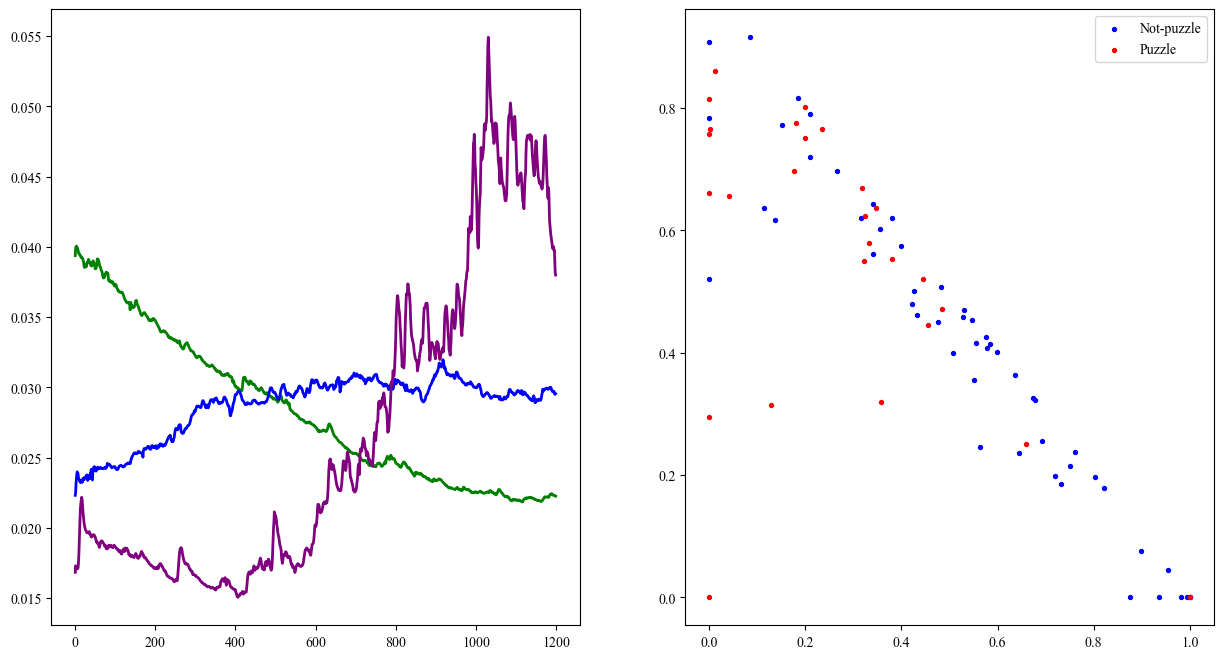

In [47]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(15,8))
ax1.plot(XC[:, 0], c='green')
ax1.plot(XC[:, 1], c='blue')
ax1.plot(XC[:, 2], c='purple')
ax2.scatter(np.asarray(S)[0, phase1_idx], np.asarray(S)[1, phase1_idx], s=8, c='blue')
ax2.scatter(np.asarray(S)[0, phase3_idx], np.asarray(S)[1, phase3_idx], s=8, c='blue', label='Not-puzzle')
ax2.scatter(np.asarray(S)[0, phase2_idx], np.asarray(S)[1, phase2_idx], s=8, c='red', label='Puzzle')
ax2.legend()
plt.show()

In [49]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
pca.fit(np.asarray(S))

PCA(n_components=2)

In [268]:
PC1, PC2 = pca.components_[0, :], pca.components_[1, :]

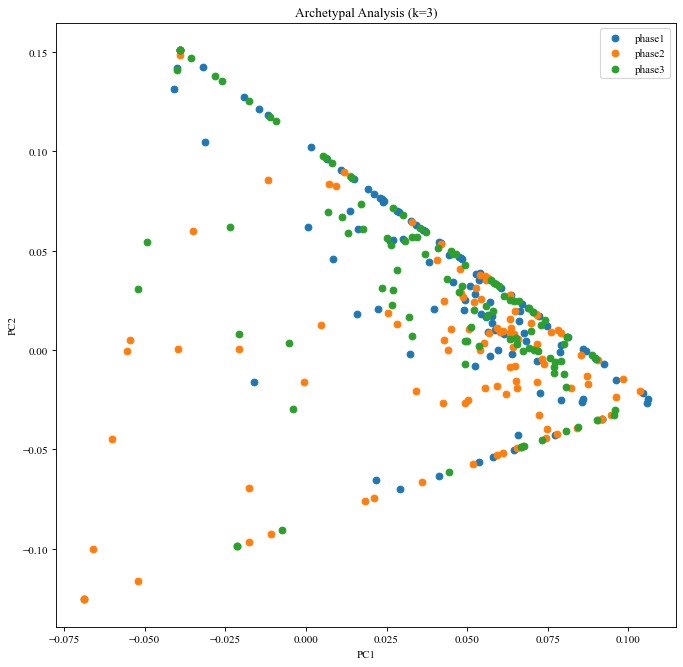

In [269]:
fig, ax = plt.subplots(figsize=(10,10), dpi=80)
ax.scatter(PC1[phase1_idx], PC2[phase1_idx], label='phase1')
ax.scatter(PC1[phase2_idx], PC2[phase2_idx], label='phase2')
ax.scatter(PC1[phase3_idx], PC2[phase3_idx], label='phase3')
ax.set_title('Archetypal Analysis (k=3)')
ax.set_xlabel('PC1')
ax.set_ylabel('PC2')
ax.legend()
plt.show()

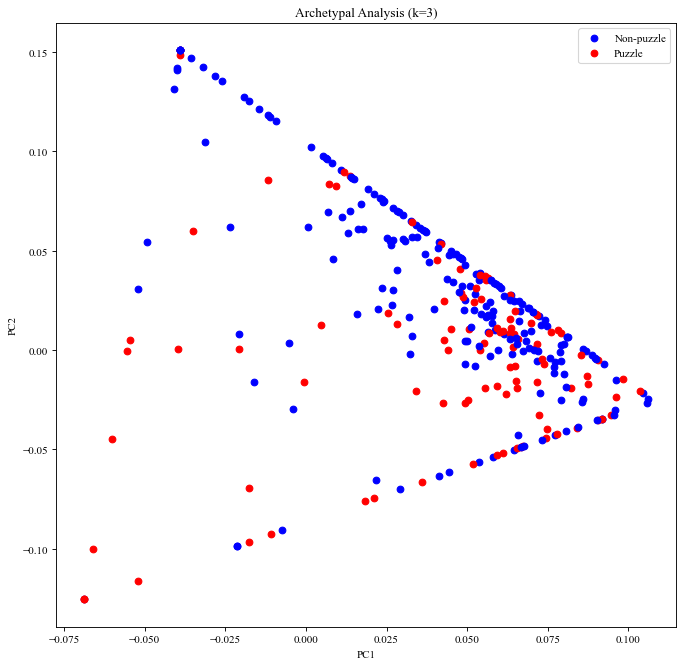

In [272]:
fig, ax = plt.subplots(figsize=(10,10), dpi=80)
ax.scatter(PC1[phase1_idx], PC2[phase1_idx], c='blue', label='Non-puzzle')
ax.scatter(PC1[phase2_idx], PC2[phase2_idx], c='red', label='Puzzle')
ax.scatter(PC1[phase3_idx], PC2[phase3_idx], c='blue')
ax.set_title('Archetypal Analysis (k=3)')
ax.set_xlabel('PC1')
ax.set_ylabel('PC2')
ax.legend()
plt.show()

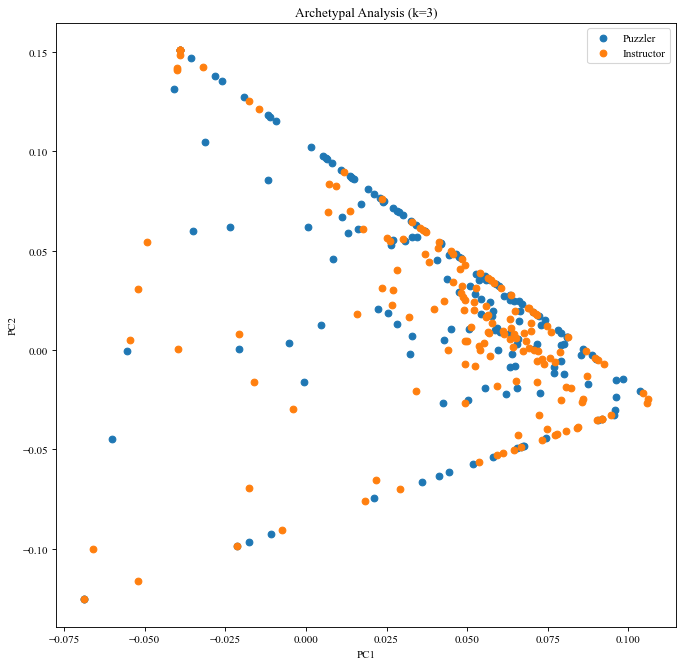

In [270]:
fig, ax = plt.subplots(figsize=(10,10), dpi=80)
ax.scatter(PC1[puzzler_idx], PC2[puzzler_idx], label='Puzzler')
ax.scatter(PC1[instructor_idx], PC2[instructor_idx], label='Instructor')
ax.set_title('Archetypal Analysis (k=3)')
ax.set_xlabel('PC1')
ax.set_ylabel('PC2')
ax.legend()
plt.show()

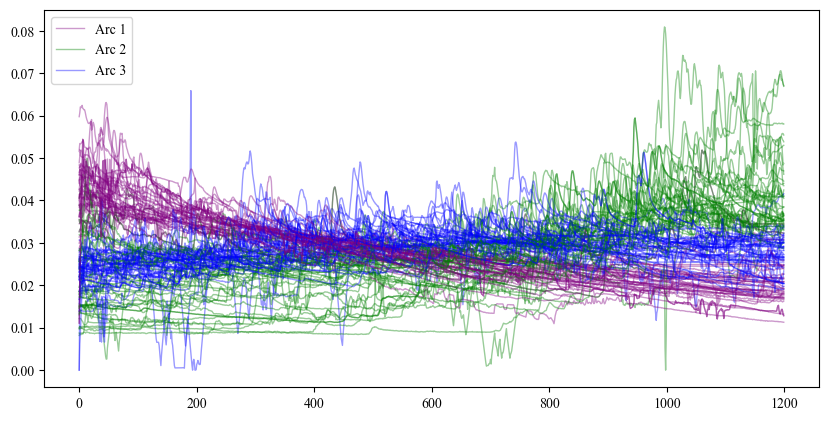

(array(['Instructor', 'Puzzler'], dtype='<U10'), array([14, 26])) (array(['Instructor', 'Puzzler'], dtype='<U10'), array([21, 19]))
(array(['phase1', 'phase2', 'phase3'], dtype='<U6'), array([13,  9, 18])) (array(['phase1', 'phase2', 'phase3'], dtype='<U6'), array([ 8, 23,  9]))


(None,
 (array(['phase1', 'phase2', 'phase3'], dtype='<U6'), array([15, 13, 12])))

In [274]:
N = 40
nearest = np.argsort(np.asarray(S), axis=1)[:, -N:]
fig, ax = plt.subplots(figsize=(10, 5), dpi=100)
for i in range(N):
    if i == N-1:
        ax.plot(X[nearest[0, i], :], c='purple', linewidth=1, alpha=0.4, label='Arc 1')
        ax.plot(X[nearest[1, i], :], c='green', linewidth=1, alpha=0.4, label='Arc 2')
        ax.plot(X[nearest[2, i], :], c='blue', linewidth=1, alpha=0.4, label='Arc 3')
    else:
        ax.plot(X[nearest[0, i], :], c='purple', linewidth=1, alpha=0.4)
        ax.plot(X[nearest[1, i], :], c='green', linewidth=1, alpha=0.4)
        ax.plot(X[nearest[2, i], :], c='blue', linewidth=1, alpha=0.4)
ax.legend()
plt.show()
print(np.unique(roles[nearest[0,:]], return_counts=True), np.unique(roles[nearest[1,:]], return_counts=True))
print(np.unique(phases[nearest[0, :]], return_counts=True), np.unique(phases[nearest[1, :]], return_counts=True)), np.unique(phases[nearest[2, :]], return_counts=True)

# BVP 

In [276]:
X = []
roles = []
phases = []
participant_ID = []

for cohort in data_dict.keys():
    for id in data_dict[cohort].keys():
        for round_ in data_dict[cohort][id].keys():
            for phase in data_dict[cohort][id][round_].keys():
                BVP_ts = data_dict[cohort][id][round_][phase]['BVP'].BVP.tolist()
                time_ts = data_dict[cohort][id][round_][phase]['BVP'].time.values.tolist()
                time_passed = data_dict[cohort][id][round_][phase]['BVP'].time_passed.tolist()
                role = data_dict[cohort][id][round_][phase]['BVP'].role.tolist()[0]
                p_id =  data_dict[cohort][id][round_][phase]['BVP'].p_ID.tolist()[0]

                # Zero padding
                if len(BVP_ts) < 1200: # 1200 equals 5 min x 60 sec x 4 samples pr second
                    BVP_ts += [BVP_ts[-1]] * (1200 - len(BVP_ts))
                elif len(BVP_ts) > 1200:
                    BVP_ts = BVP_ts[:1200]
                roles.append(role)
                phases.append(phase)
                participant_ID.append(p_id)
                X += [BVP_ts]

roles = np.array(roles)
phases = np.array(phases)
X = np.vstack(X)
X.shape

(312, 1200)

In [277]:
X = unit_normalize(X)

In [278]:
from py_pcha import PCHA
# Notice that for this implementation we transform the data matrix X
XC, S, C, SSE, varexl = PCHA(X.T, noc=3)
X_hat = X.T @ C @ S
components = XC.T

[[47.50358603 25.04887103 22.45826168]
 [25.04887103 61.95034614 28.5578439 ]
 [22.45826168 28.5578439  50.41611461]]
0.0061132117996294255


In [279]:
phase1_idx = np.where(phases=='phase1')[0]
phase2_idx = np.where(phases=='phase2')[0]
phase3_idx = np.where(phases=='phase3')[0]

puzzler_idx = np.where(roles=='Puzzler')[0]
instructor_idx = np.where(roles=='Instructor')[0]

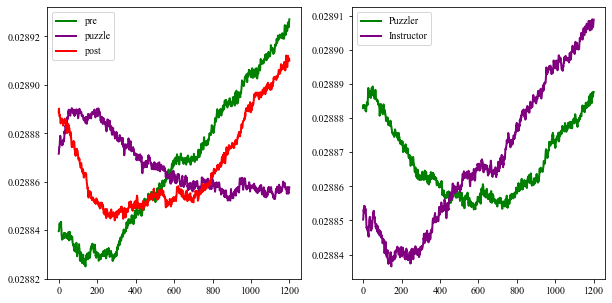

In [280]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,5))
ax1.plot(X[phase1_idx, :].mean(axis=0), c='green', label='pre')
ax1.plot(X[phase2_idx, :].mean(axis=0), c='purple', label='puzzle')
ax1.plot(X[phase3_idx, :].mean(axis=0), c='red', label='post')
ax1.legend()

ax2.plot(X[puzzler_idx, :].mean(axis=0), c='green', label='Puzzler')
ax2.plot(X[instructor_idx, :].mean(axis=0), c='purple', label='Instructor')
ax2.legend()
plt.show()

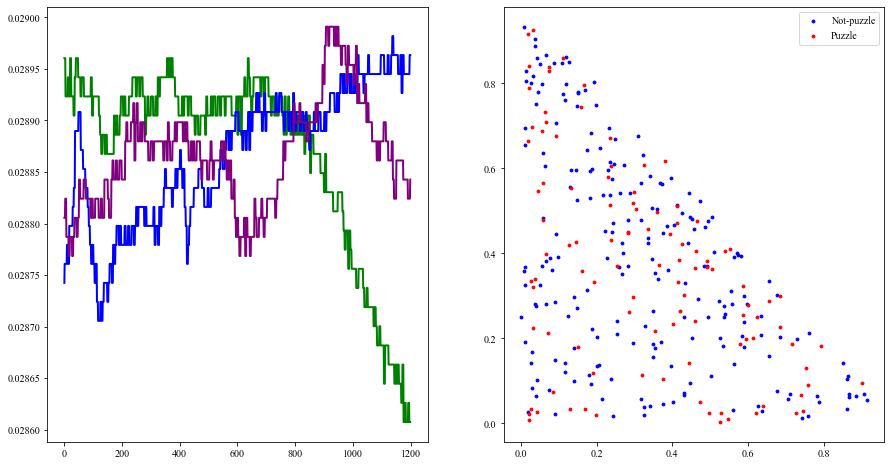

In [281]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(15,8))
ax1.plot(XC[:, 0], c='green')
ax1.plot(XC[:, 1], c='blue')
ax1.plot(XC[:, 2], c='purple')
ax2.scatter(np.asarray(S)[0, phase1_idx], np.asarray(S)[1, phase1_idx], s=8, c='blue')
ax2.scatter(np.asarray(S)[0, phase3_idx], np.asarray(S)[1, phase3_idx], s=8, c='blue', label='Not-puzzle')
ax2.scatter(np.asarray(S)[0, phase2_idx], np.asarray(S)[1, phase2_idx], s=8, c='red', label='Puzzle')
ax2.legend()
plt.show()

In [282]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
pca.fit(S)
PC1, PC2 = pca.components_[0, :], pca.components_[1, :]

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/utils/validation.py:727: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  warnings.warn(


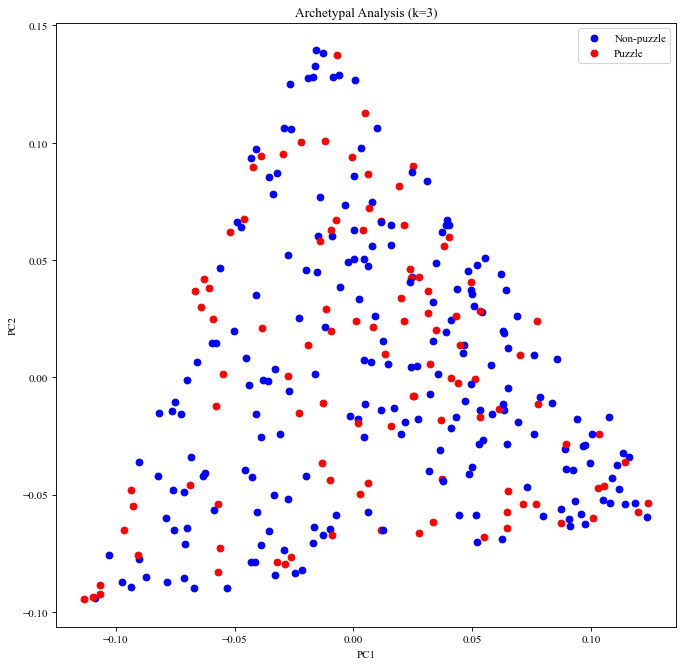

In [283]:
fig, ax = plt.subplots(figsize=(10,10), dpi=80)
ax.scatter(PC1[phase1_idx], PC2[phase1_idx], c='blue', label='Non-puzzle')
ax.scatter(PC1[phase2_idx], PC2[phase2_idx], c='red', label='Puzzle')
ax.scatter(PC1[phase3_idx], PC2[phase3_idx], c='blue')
ax.set_title('Archetypal Analysis (k=3)')
ax.set_xlabel('PC1')
ax.set_ylabel('PC2')
ax.legend()
plt.show()

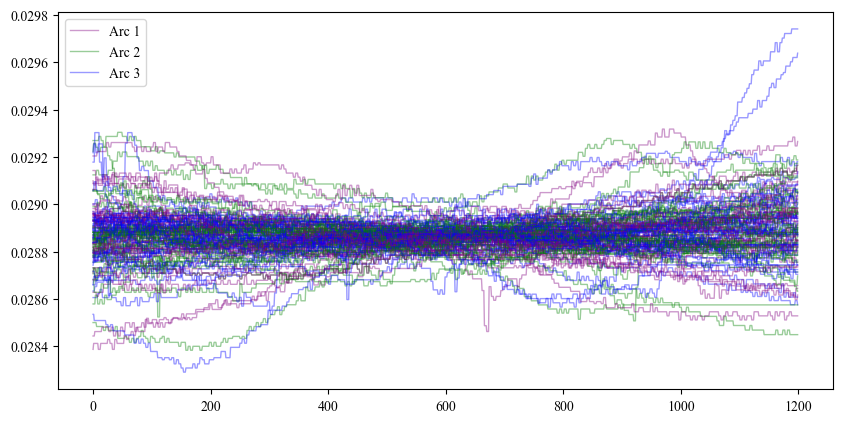

(array(['Instructor', 'Puzzler'], dtype='<U10'), array([18, 22])) (array(['Instructor', 'Puzzler'], dtype='<U10'), array([23, 17]))
(array(['phase1', 'phase2', 'phase3'], dtype='<U6'), array([14, 14, 12])) (array(['phase1', 'phase2', 'phase3'], dtype='<U6'), array([12, 12, 16])) (array(['phase1', 'phase2', 'phase3'], dtype='<U6'), array([19, 13,  8]))


In [285]:
N = 40
nearest = np.argsort(np.asarray(S), axis=1)[:, -N:]
fig, ax = plt.subplots(figsize=(10, 5), dpi=100)
for i in range(N):
    if i == N-1:
        ax.plot(X[nearest[0, i], :], c='purple', linewidth=1, alpha=0.4, label='Arc 1')
        ax.plot(X[nearest[1, i], :], c='green', linewidth=1, alpha=0.4, label='Arc 2')
        ax.plot(X[nearest[2, i], :], c='blue', linewidth=1, alpha=0.4, label='Arc 3')
    else:
        ax.plot(X[nearest[0, i], :], c='purple', linewidth=1, alpha=0.4)
        ax.plot(X[nearest[1, i], :], c='green', linewidth=1, alpha=0.4)
        ax.plot(X[nearest[2, i], :], c='blue', linewidth=1, alpha=0.4)
ax.legend()
plt.show()
print(np.unique(roles[nearest[0,:]], return_counts=True), np.unique(roles[nearest[1,:]], return_counts=True))
print(np.unique(phases[nearest[0, :]], return_counts=True), np.unique(phases[nearest[1, :]], return_counts=True), np.unique(phases[nearest[2, :]], return_counts=True))

# BVP

In [327]:
X = []
roles = []
phases = []
participant_ID = []

for cohort in data_dict.keys():
    for id in data_dict[cohort].keys():
        for round_ in data_dict[cohort][id].keys():
            for phase in data_dict[cohort][id][round_].keys():
                BVP_ts = data_dict[cohort][id][round_][phase]['BVP'].BVP.tolist()
                time_ts = data_dict[cohort][id][round_][phase]['BVP'].time.values.tolist()
                time_passed = data_dict[cohort][id][round_][phase]['BVP'].time_passed.tolist()
                role = data_dict[cohort][id][round_][phase]['BVP'].role.tolist()[0]
                p_id =  data_dict[cohort][id][round_][phase]['BVP'].p_ID.tolist()[0]

                # Zero padding
                if len(BVP_ts) < 19200: # 1200 equals 5 min x 60 sec x 4 samples pr second
                    BVP_ts += [BVP_ts[-1]] * (19200 - len(BVP_ts))
                elif len(BVP_ts) > 19200:
                    BVP_ts = BVP_ts[:19200]

                BVP_ts = BVP_ts[1000:]
                roles.append(role)
                phases.append(phase)
                participant_ID.append(p_id)
                X += [BVP_ts]

roles = np.array(roles)
phases = np.array(phases)
X = np.vstack(X)
X.shape

(312, 14000)

In [328]:
X = unit_normalize(X)

In [329]:
from py_pcha import PCHA
# Notice that for this implementation we transform the data matrix X
XC, S, C, SSE, varexl = PCHA(X.T, noc=3)
X_hat = X.T @ C @ S
components = XC.T

[[54.9866354  26.52023451 25.75014191]
 [26.52023451 47.49742904 25.73072723]
 [25.75014191 25.73072723 53.51372826]]
468.56807992536665


In [330]:
phase1_idx = np.where(phases=='phase1')[0]
phase2_idx = np.where(phases=='phase2')[0]
phase3_idx = np.where(phases=='phase3')[0]

puzzler_idx = np.where(roles=='Puzzler')[0]
instructor_idx = np.where(roles=='Instructor')[0]

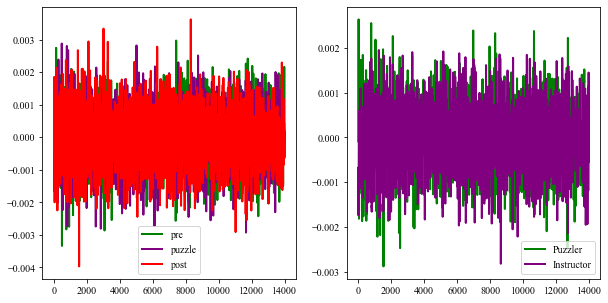

In [331]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,5))
ax1.plot(X[phase1_idx, :].mean(axis=0), c='green', label='pre')
ax1.plot(X[phase2_idx, :].mean(axis=0), c='purple', label='puzzle')
ax1.plot(X[phase3_idx, :].mean(axis=0), c='red', label='post')
ax1.legend()

ax2.plot(X[puzzler_idx, :].mean(axis=0), c='green', label='Puzzler')
ax2.plot(X[instructor_idx, :].mean(axis=0), c='purple', label='Instructor')
ax2.legend()
plt.show()

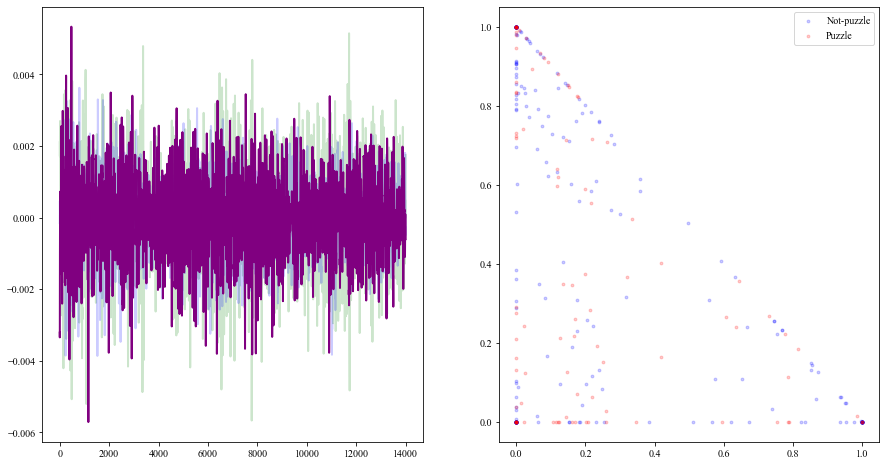

In [332]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(15,8))
ax1.plot(XC[:, 0], c='green', alpha=.2)
ax1.plot(XC[:, 1], c='blue', alpha=.2)
ax1.plot(XC[:, 2], c='purple')
ax2.scatter(np.asarray(S)[0, phase1_idx], np.asarray(S)[1, phase1_idx], alpha=0.2, s=8, c='blue')
ax2.scatter(np.asarray(S)[0, phase3_idx], np.asarray(S)[1, phase3_idx], alpha=0.2, s=8, c='blue', label='Not-puzzle')
ax2.scatter(np.asarray(S)[0, phase2_idx], np.asarray(S)[1, phase2_idx], alpha=0.2, s=8, c='red', label='Puzzle')
ax2.legend()
plt.show()

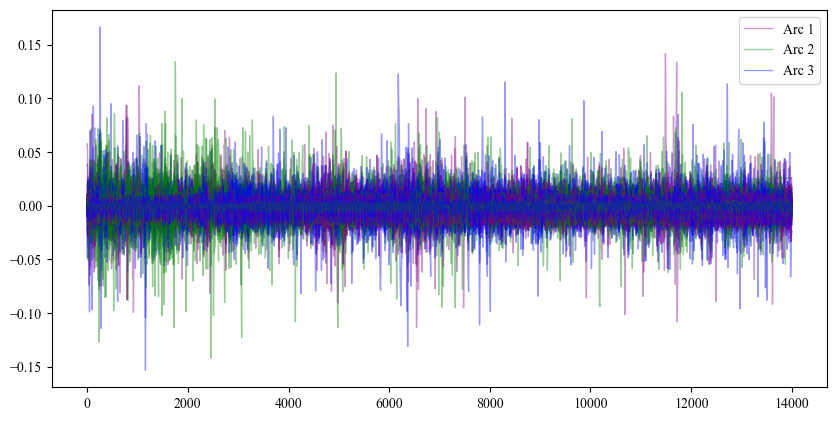

(array(['Instructor', 'Puzzler'], dtype='<U10'), array([21, 19])) (array(['Instructor', 'Puzzler'], dtype='<U10'), array([13, 27]))
(array(['phase1', 'phase2', 'phase3'], dtype='<U6'), array([14,  5, 21])) (array(['phase1', 'phase2', 'phase3'], dtype='<U6'), array([13, 12, 15])) (array(['phase1', 'phase2', 'phase3'], dtype='<U6'), array([16, 11, 13]))


In [333]:
N = 40
nearest = np.argsort(np.asarray(S), axis=1)[:, -N:]
fig, ax = plt.subplots(figsize=(10, 5), dpi=100)
for i in range(N):
    if i == N-1:
        ax.plot(X[nearest[0, i], :], c='purple', linewidth=1, alpha=0.4, label='Arc 1')
        ax.plot(X[nearest[1, i], :], c='green', linewidth=1, alpha=0.4, label='Arc 2')
        ax.plot(X[nearest[2, i], :], c='blue', linewidth=1, alpha=0.4, label='Arc 3')
    else:
        ax.plot(X[nearest[0, i], :], c='purple', linewidth=1, alpha=0.4)
        ax.plot(X[nearest[1, i], :], c='green', linewidth=1, alpha=0.4)
        ax.plot(X[nearest[2, i], :], c='blue', linewidth=1, alpha=0.4)
ax.legend()
plt.show()
print(np.unique(roles[nearest[0,:]], return_counts=True), np.unique(roles[nearest[1,:]], return_counts=True))
print(np.unique(phases[nearest[0, :]], return_counts=True), np.unique(phases[nearest[1, :]], return_counts=True), np.unique(phases[nearest[2, :]], return_counts=True))

# Aggregated

In [351]:
min_len_hr = min(len(data_dict[cohort][id][round_][phase]['HR']['HR'].tolist()) for cohort in data_dict for id in data_dict[cohort] for round_ in data_dict[cohort][id] for phase in data_dict[cohort][id][round_] if len(data_dict[cohort][id][round_][phase]['HR']['HR'].tolist()) > mu_lengths - std_lengths)
max_len_hr = max(len(data_dict[cohort][id][round_][phase]['HR']['HR'].tolist()) for cohort in data_dict for id in data_dict[cohort] for round_ in data_dict[cohort][id] for phase in data_dict[cohort][id][round_] if len(data_dict[cohort][id][round_][phase]['HR']['HR'].tolist()) > mu_lengths - std_lengths)
columns = ['ID', 'time', 'time_passed', 'D', 'round', 'phase', 'HR']
X = []
roles = []
phases = []
participant_ID = []

for cohort in data_dict.keys():
    for id in data_dict[cohort].keys():
        for phase in ['phase1', 'phase2', 'phase3']:
            series_temp = []
            for round_ in data_dict[cohort][id].keys():
                hr_ts = data_dict[cohort][id][round_][phase]['HR'].HR.tolist()
                time_ts = data_dict[cohort][id][round_][phase]['HR'].time.values.tolist()
                time_passed = data_dict[cohort][id][round_][phase]['HR'].time_passed.tolist()
                role = data_dict[cohort][id][round_][phase]['HR'].role.tolist()[0]
                p_id =  data_dict[cohort][id][round_][phase]['HR'].p_ID.tolist()[0]

                # Zero padding
                if len(hr_ts) < 300:
                    hr_ts += [hr_ts[-1]] * (300 - len(hr_ts))
                elif len(hr_ts) > 300:
                    hr_ts = hr_ts[:300]
                participant_ID.append(p_id)
                series_temp.append(hr_ts)
            roles.append(role)
            phases.append(phase)
            X += [np.array(series_temp).mean(axis=0)]
roles = np.array(roles)
phases = np.array(phases)
X = np.vstack(X)
X.shape

(78, 300)

In [352]:
X = unit_normalize(X)

In [357]:
from py_pcha import PCHA
# Notice that for this implementation we transform the data matrix X
XC, S, C, SSE, varexl = PCHA(X.T, noc=2)
X_hat = X.T @ C @ S
components = XC.T

[[24.6601833  13.77751043]
 [13.77751043 25.78479584]]
0.5875817300969999


In [358]:
S.shape

(2, 78)

In [359]:
phase1_idx = np.where(phases=='phase1')[0]
phase2_idx = np.where(phases=='phase2')[0]
phase3_idx = np.where(phases=='phase3')[0]

puzzler_idx = np.where(roles=='Puzzler')[0]
instructor_idx = np.where(roles=='Instructor')[0]

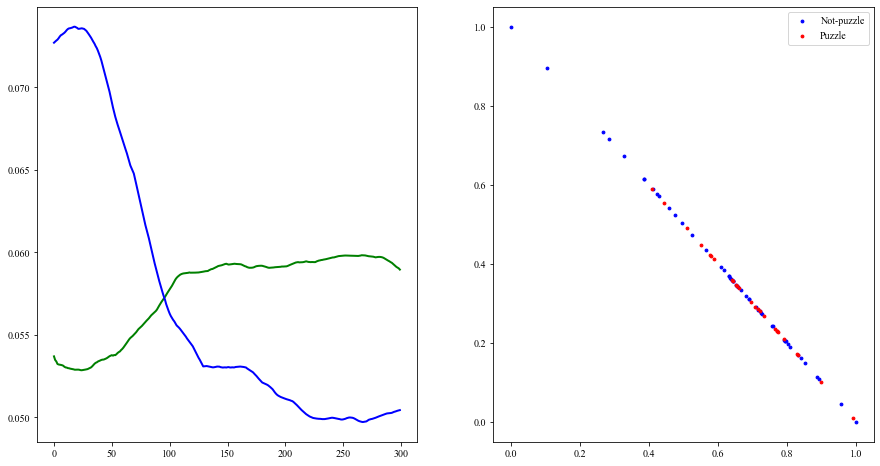

In [361]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(15,8))
ax1.plot(XC[:, 0], c='green')
ax1.plot(XC[:, 1], c='blue')
#ax1.plot(XC[:, 2], c='purple')
ax2.scatter(np.asarray(S)[0, phase1_idx], np.asarray(S)[1, phase1_idx], s=8, c='blue')
ax2.scatter(np.asarray(S)[0, phase3_idx], np.asarray(S)[1, phase3_idx], s=8, c='blue', label='Not-puzzle')
ax2.scatter(np.asarray(S)[0, phase2_idx], np.asarray(S)[1, phase2_idx], s=8, c='red', label='Puzzle')
ax2.legend()
plt.show()